In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
import pandas as pd
from utils import MONTH_NAMES_RU
from collections import defaultdict

globsnow_path = '../data/prepare/globsnow/'
era5_path = '../data/prepare/era5_swe/'
figures_dir = "../figures/prepare/swe/"

os.makedirs(figures_dir, exist_ok=True)

In [2]:
def process_file(file, date, prefix):
    filepath = os.path.join(prefix, file)
    if not os.path.exists(filepath):
        return []
    ds = xr.open_dataset(filepath, engine="h5netcdf")
    val = ds.swe.to_numpy()
    ds.close()
    mask = (~np.isnan(val)) & (val > 0.1)
    if np.sum(mask) == 0:
        return []
    mean = val[mask].mean()
    count = len(val[mask])
    return [date, mean, count]

def process_date(file):
    date = datetime.strptime(file[:8], "%Y%m%d")
    globsnow_stat = process_file(file, date, globsnow_path)
    era5_stat = process_file(file, date, era5_path)

    result = []
    if globsnow_stat:
        result.append(globsnow_stat + ['globsnow'])
    if era5_stat:  
        result.append(era5_stat + ['era5'])
    
    return result

files = [f for f in os.listdir(era5_path)]
with ProcessPoolExecutor() as executor:
    stats = list(tqdm(executor.map(process_date, files), total=len(files)))
    stats = [item for outer in stats for item in outer]
    stats_df = pd.DataFrame(stats, columns=["date", "mean", "count", "archive"])
    stats_df['month'] = stats_df['date'].dt.month
    era5_df = stats_df[stats_df['archive'] == 'era5']
    globsnow_df = stats_df[stats_df['archive'] == 'globsnow']

  0%|          | 0/12711 [00:00<?, ?it/s]

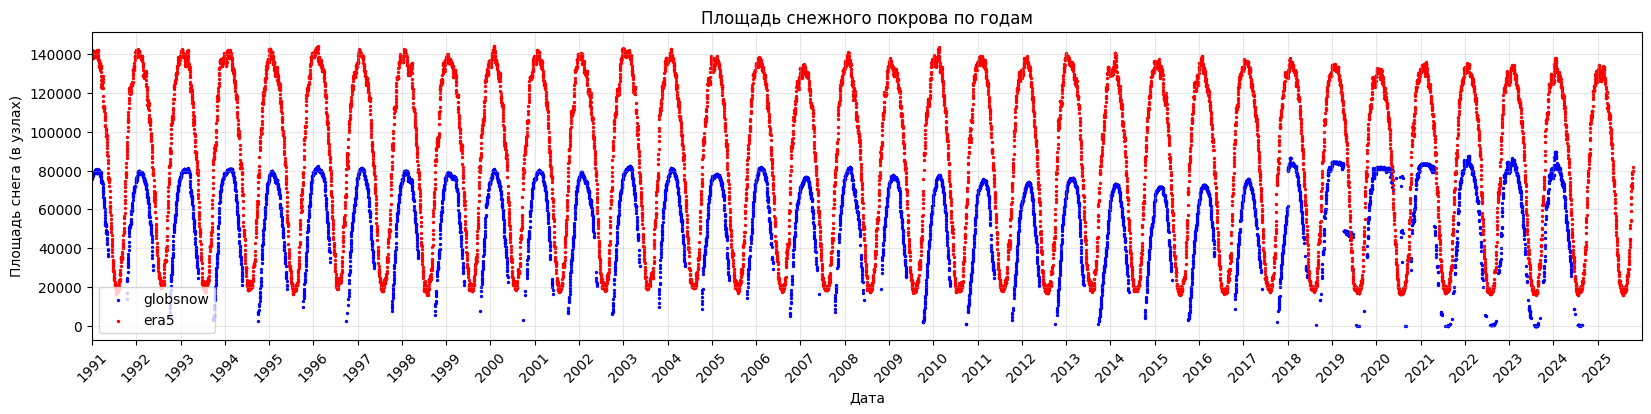

In [3]:
years = range(1991, 2026)

plt.figure(figsize=(20, 4))
plt.scatter(globsnow_df["date"], globsnow_df["count"], s=2, c='b')
plt.scatter(era5_df["date"], era5_df["count"], s=2, c='r')
plt.xlabel("Дата")
plt.ylabel("Площадь снега (в узлах)")
plt.title("Площадь снежного покрова по годам")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xticks([pd.Timestamp(year, 1, 1) for year in years], years)
plt.xlim([pd.Timestamp(1991, 1, 1), pd.Timestamp(2026, 1, 1)])
plt.legend(['globsnow', 'era5'])
plt.savefig(figures_dir + 'cover_by_years.png', dpi=150, bbox_inches='tight')
plt.show()

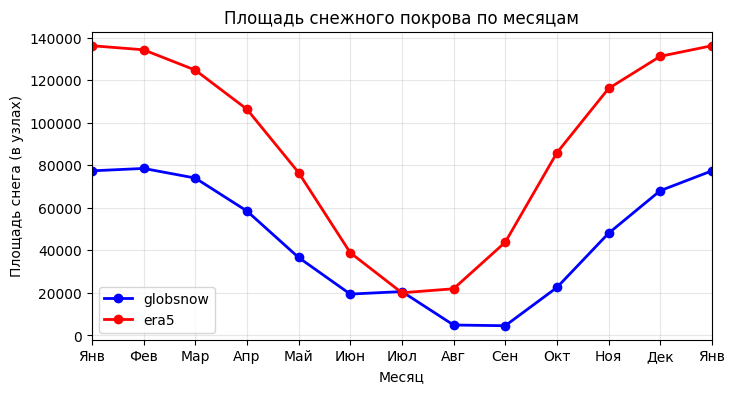

In [5]:
globsnow_monthly_mean = globsnow_df.groupby('month').agg({'count': 'mean', 'mean': 'mean'})
globsnow_monthly_mean = pd.concat([globsnow_monthly_mean, globsnow_monthly_mean.loc[[1]].rename({1: 13})])
era5_monthly_mean = era5_df.groupby('month').agg({'count': 'mean', 'mean': 'mean'})
era5_monthly_mean = pd.concat([era5_monthly_mean, era5_monthly_mean.loc[[1]].rename({1: 13})])

plt.figure(figsize=(8, 4))
plt.plot(globsnow_monthly_mean.index, globsnow_monthly_mean['count'], marker='o', linewidth=2, color='b')
plt.plot(era5_monthly_mean.index, era5_monthly_mean['count'], marker='o', linewidth=2, color='r')
plt.xlabel("Месяц")
plt.ylabel("Площадь снега (в узлах)")
plt.title("Площадь снежного покрова по месяцам")
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 14), MONTH_NAMES_RU + [MONTH_NAMES_RU[0]])
plt.xlim(1, 13)
plt.legend(['globsnow', 'era5'])
plt.savefig(figures_dir + 'cover_by_months.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
def process_month_archive(month, files, archive):
    if len(files) == 0:
        return

    figures_achive_dir = os.path.join(figures_dir, archive)
    os.makedirs(figures_achive_dir, exist_ok=True)

    mean = np.zeros((361, 1440))
    for i, file in enumerate(files):
        if i % 100 == 0:
            print(f"{archive}, {month}: {i+1}/{len(files)}")
        ds = xr.open_dataset(file, engine="h5netcdf")
        mean += ds.swe.to_numpy()
        if i == 0:
            lat = ds.lat.to_numpy()
            lon = ds.lon.to_numpy()
        ds.close()

    mean /= len(files)

    fig, ax = plt.subplots(figsize=(12, 6))
    levels = np.linspace(0, 4, 101)
    contour = ax.contourf(lon, lat, np.log10(mean + 1), levels, cmap='Blues')
    cb = fig.colorbar(contour)
    cb.set_label('Водный эквивалент снега, log10(мм)')
    month_name = MONTH_NAMES_RU[month-1]
    ax.set_title(f'Средний водный эквивалент снега, {archive}, {month_name}')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    fig.savefig(os.path.join(figures_achive_dir, f"month_{month}.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)

def process_month(data):
    globsnow_files, era5_files = data[1]
    process_month_archive(data[0], globsnow_files, "globsnow")
    process_month_archive(data[0], era5_files, "era5")

files_by_month = defaultdict(lambda: ([], []))
for file in os.listdir(globsnow_path):
    date = datetime.strptime(file[:8], "%Y%m%d")
    files_by_month[date.month][0].append(os.path.join(globsnow_path, file))
for file in os.listdir(era5_path):
    date = datetime.strptime(file[:8], "%Y%m%d")  
    files_by_month[date.month][1].append(os.path.join(era5_path, file)) 

with ProcessPoolExecutor() as executor:
    executor.map(process_month, list(files_by_month.items()))

globsnow, 1: 1/1026globsnow, 11: 1/954globsnow, 4: 1/982globsnow, 5: 1/613globsnow, 10: 1/588globsnow, 2: 1/939globsnow, 3: 1/1033

globsnow, 8: 1/59
globsnow, 12: 1/1002
globsnow, 9: 1/20globsnow, 6: 1/50globsnow, 7: 1/18







era5, 7: 1/1085
era5, 9: 1/1050
era5, 6: 1/1050
era5, 8: 1/1085
globsnow, 10: 101/588
globsnow, 5: 101/613
globsnow, 11: 101/954
globsnow, 4: 101/982
globsnow, 12: 101/1002
globsnow, 1: 101/1026
globsnow, 3: 101/1033
globsnow, 2: 101/939
era5, 7: 101/1085
globsnow, 10: 201/588
era5, 9: 101/1050
globsnow, 11: 201/954
era5, 6: 101/1050
globsnow, 12: 201/1002
era5, 8: 101/1085
globsnow, 4: 201/982
globsnow, 5: 201/613
globsnow, 1: 201/1026
globsnow, 2: 201/939
globsnow, 3: 201/1033
era5, 7: 201/1085
era5, 6: 201/1050
globsnow, 10: 301/588
era5, 9: 201/1050
era5, 8: 201/1085
globsnow, 11: 301/954
era5, 7: 301/1085
globsnow, 3: 301/1033
globsnow, 4: 301/982
globsnow, 5: 301/613
globsnow, 1: 301/1026
globsnow, 12: 301/1002
globsnow, 2: 301/939
globsnow, 10: 401/588
